In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import lightgbm as lgb

df = pd.read_csv("../data/cleaned/final_merged_dataset.csv")

# ---------------------------
# 1. Encode categorical features
# ---------------------------
le_state = LabelEncoder()
le_crime = LabelEncoder()

df['State_encoded'] = le_state.fit_transform(df['State'])
df['Crime_encoded'] = le_crime.fit_transform(df['Crime_Type'])

features = [
    'State_encoded', 'Crime_encoded', 'Year',
    'unemployment_rate', 'poverty_rate', 'per_capita_income',
    'inflation_rate', 'population_density', 'gender_ratio',
    'literacy_rate','youth_population_percent', 'urbanization_rate',
    'human_development_index', 'police_stations_per_district',
    'conviction_rate', 'police_personnel_per_100k',
    'alcohol_consumption_per_capita'
]

target = 'Cases'

train_df = df[df['Year'] <= 2020]
test_df  = df[df['Year'] > 2020]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

model = lgb.LGBMRegressor(
    n_estimators=700,
    learning_rate=0.015,
    max_depth=-1,
    num_leaves=64,
    subsample=0.85,
    colsample_bytree=0.95,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=40
)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("TRAIN PERFORMANCE:")
print("R2:", r2_score(y_train, pred_train))
print("MAE:", mean_absolute_error(y_train, pred_train))
print("RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

print("\nTEST PERFORMANCE:")
print("R2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", sqrt(mean_squared_error(y_test, pred_test)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2785
[LightGBM] [Info] Number of data points in the train set: 6300, number of used features: 17
[LightGBM] [Info] Start training from score 2511.639524
TRAIN PERFORMANCE:
R2: 0.8351456748082894
MAE: 935.4403633622261
RMSE: 3315.6880155235904

TEST PERFORMANCE:
R2: 0.7650636765113348
MAE: 1293.7197268673121
RMSE: 3401.949560375892


In [4]:
import joblib

# Save final tuned model inside models folder
joblib.dump(model, "../model/lightgbm_model.pkl")

print("Model saved successfully in ../models/lightgbm_model.pkl")


Model saved successfully in ../models/lightgbm_model.pkl


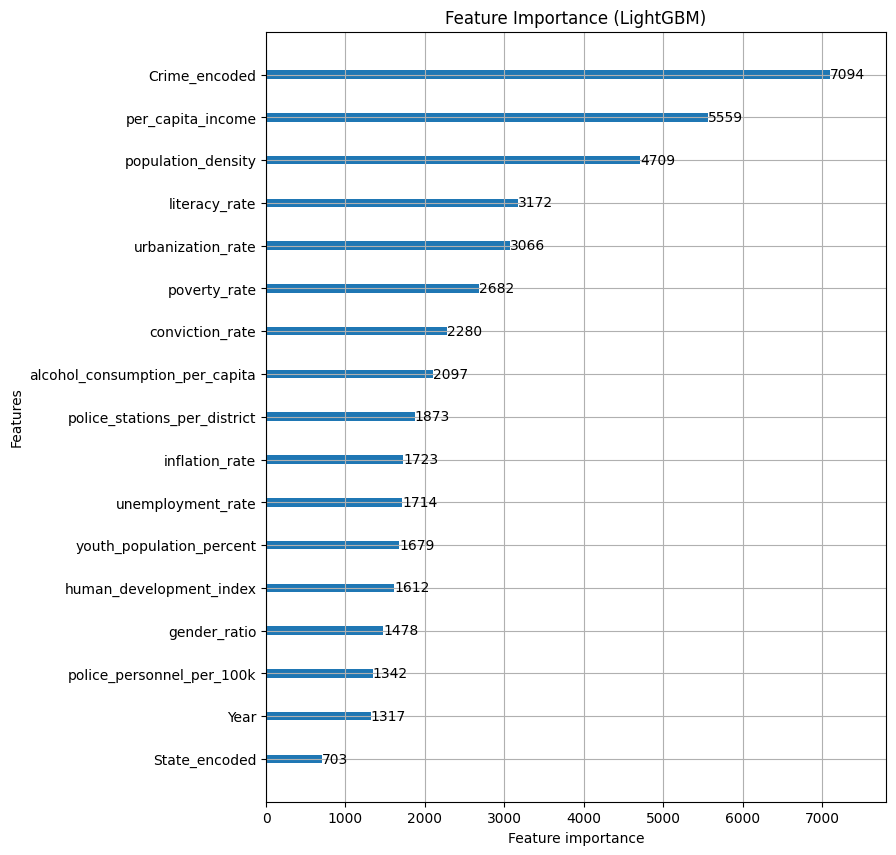

In [6]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=20, figsize=(8,10))
plt.title("Feature Importance (LightGBM)")
plt.show()


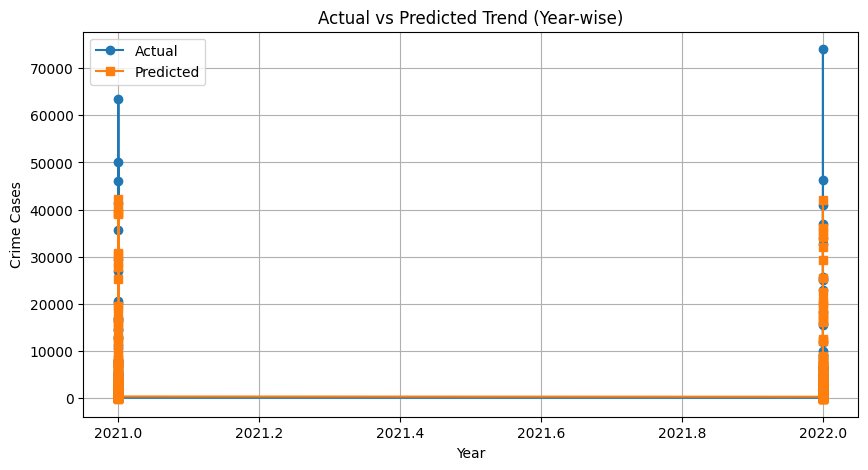

In [7]:
test_df_sorted = test_df.copy()
test_df_sorted["Predicted"] = pred_test
test_df_sorted = test_df_sorted.sort_values(by="Year")

plt.figure(figsize=(10,5))
plt.plot(test_df_sorted["Year"], test_df_sorted["Cases"], label="Actual", marker='o')
plt.plot(test_df_sorted["Year"], test_df_sorted["Predicted"], label="Predicted", marker='s')
plt.xlabel("Year")
plt.ylabel("Crime Cases")
plt.title("Actual vs Predicted Trend (Year-wise)")
plt.legend()
plt.grid(True)
plt.show()


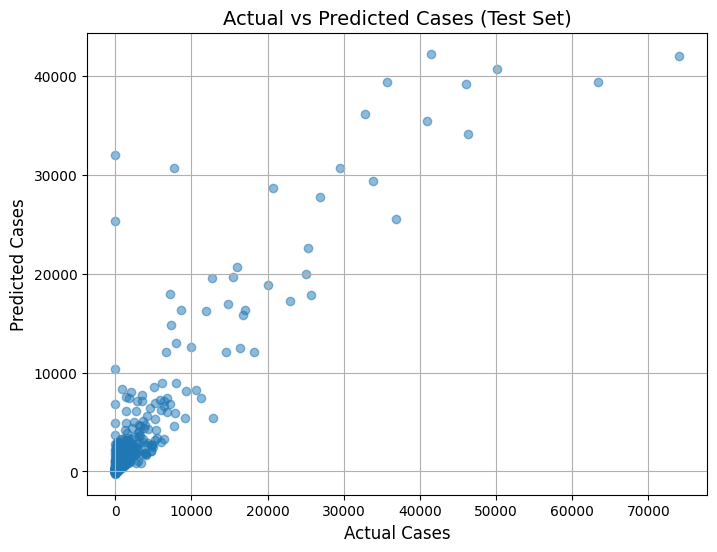

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_test, alpha=0.5)
plt.xlabel("Actual Cases", fontsize=12)
plt.ylabel("Predicted Cases", fontsize=12)
plt.title("Actual vs Predicted Cases (Test Set)", fontsize=14)
plt.grid(True)
plt.show()


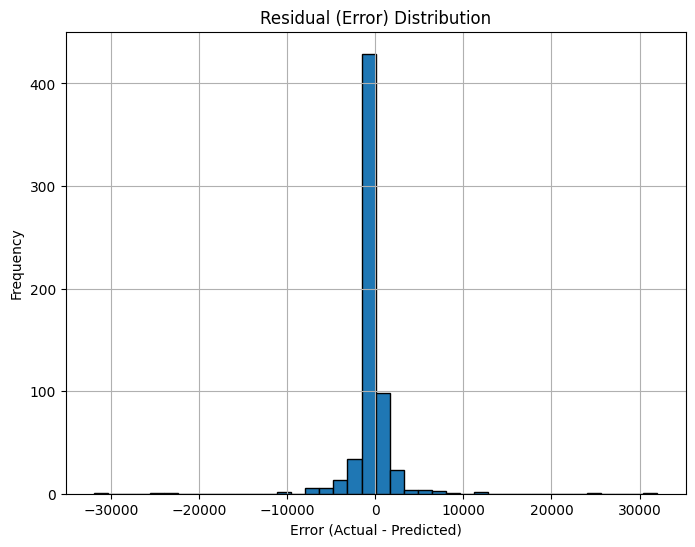

In [10]:
errors = y_test - pred_test

plt.figure(figsize=(8,6))
plt.hist(errors, bins=40, edgecolor='black')
plt.title("Residual (Error) Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
